<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/nlp/101/word2vec_a_study_of_embeddings_in_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly -qq

In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/word2vec/word2vec.zip
!unzip -qq word2vec.zip
%cd word2vec

--2024-01-14 22:42:37--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/word2vec/word2vec.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.82.189, 3.5.80.149, 52.218.180.41, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.82.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190090 (186K) [binary/octet-stream]
Saving to: ‘word2vec.zip’

word2vec.zip        100%[===================>] 185.63K   873KB/s    in 0.2s    

2024-01-14 22:42:38 (873 KB/s) - ‘word2vec.zip’ saved [190090/190090]

/content/word2vec


In [3]:
import os

import tensorflow as tf
tf.random.set_seed(42)

from sklearn.manifold import TSNE
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

In [4]:
class Config:
    EMBEDDING_SIZE = 10

    WINDOW_SIZE = 5
    ITERATIONS = 200

    OUTPUT_PATH = "outputs"

    # path to skipgram outputs
    SKIPGRAM_LOSS = os.path.join(OUTPUT_PATH, "loss_skipgram")
    SKIPGRAM_LOSS = os.path.join(OUTPUT_PATH, "tsne_skipgram")

    # path to CBOW outputs
    CBOW_LOSS = os.path.join(OUTPUT_PATH, "loss_cbow")
    CBOW_LOSS = os.path.join(OUTPUT_PATH, "tsne_cbow")

config = Config()

### Tokenize the data

In [25]:
def tokenize_data(data):
    # convert data into tokens
    tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(data)
    # tokenized_text = tf.strings.split(data).ref()
    # print(tokenized_text)

    # create and store vocabulary of unique words
    # along with the size of the tokenized texts
    vocab = sorted(set(tokenized_text))
    tokenized_text_size = len(tokenized_text)

    return (vocab, tokenized_text_size, tokenized_text)

### CBOW

In [9]:
# read input data from disk
print("[INFO] reading data from file...")
with open("data.txt", "r") as fp:
    lines = fp.readlines()
text_data = "".join(lines)

[INFO] reading data from file...


In [26]:
# tokenize text data
(vocab, tokenized_text_size, tokenized_text) = tokenize_data(text_data)

# map vocab words to individual indices
# and map the indices to the words in vocab
vocab_to_index = {unique_word:idx for (idx, unique_word) in enumerate(vocab)}
index_to_vocab = np.array(vocab)

# convert tokens to numbers
text_as_int = np.array([vocab_to_index[word] for word in tokenized_text])

# create representational matrices as variable tensors
context_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, config.EMBEDDING_SIZE)
)
center_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, config.EMBEDDING_SIZE)
)

In [28]:
# init optimizer and create empty list to log loss
optimizer = tf.optimizers.Adam()
loss_list = list()

# loop over training epochs
print("[INFO] Starting CBOW training...")
for iter in tqdm(range(config.ITERATIONS)):
    # init loss per epoch
    loss_per_epoch = 0

    # the window for center vector prediction is created
    for start in range(tokenized_text_size - config.WINDOW_SIZE):
        # generate indices for the window
        indices = text_as_int[start:start + config.WINDOW_SIZE]

        # init gradient tape
        with tf.GradientTape() as tape:
            # init context vector
            combined_context = 0

            # loop over indices and grab neighboring word representation
            # from embedding matrix
            for (count, idx) in enumerate(indices):
                if count != config.WINDOW_SIZE // 2:
                    combined_context += context_vector_matrix[idx, :]

            # standardize result according to window size
            combined_context /= (config.WINDOW_SIZE - 1)

            # calculate center word embedding predictions
            output = tf.matmul(
                center_vector_matrix,
                tf.expand_dims(combined_context, 1)
            )

            # apply softmax loss and grab relevant index
            soft_out = tf.nn.softmax(output, axis=0)
            loss = soft_out[indices[config.WINDOW_SIZE // 2]]

            # calculate log loss
            log_loss = -tf.math.log(loss)

        # update loss per epoch
        loss_per_epoch += log_loss.numpy()
        # apply gradients to embedding matrices
        grad = tape.gradient(
            log_loss, [context_vector_matrix, center_vector_matrix]
        )
        optimizer.apply_gradients(
            zip(grad, [context_vector_matrix, center_vector_matrix])
        )

    # update loss list
    loss_list.append(loss_per_epoch)

[INFO] Starting CBOW training...


100%|██████████| 200/200 [20:04<00:00,  6.02s/it]


[INFO] Plotting loss...


Text(0, 0.5, 'loss')

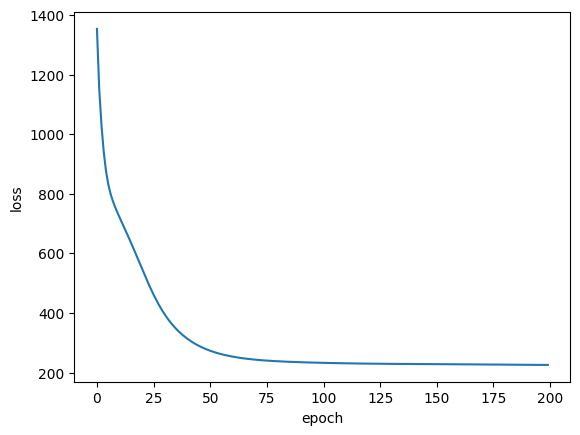

In [36]:
# plot the loss for evaluation
print("[INFO] Plotting loss...")
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")

In [30]:
# apply dimensional reductionality using tsne for representation matrices
tsne_embed = (
    TSNE(n_components=2).fit_transform(center_vector_matrix.numpy())
)
tsne_decode = (
    TSNE(n_components=2).fit_transform(context_vector_matrix.numpy())
)

In [31]:
# build a dataset of tsne for plotly
cbow_tsne_df = pd.DataFrame(
    {
        "x": tsne_decode[:100, 0],
        "y": tsne_decode[:100, 1],
        "word": index_to_vocab[list(range(100))]
    }
)

In [32]:
# tsne plot
px.scatter(data_frame=cbow_tsne_df, x="x", y="y", hover_data=["word"])

### Skip Gram

In [33]:
# read input data from disk
print("[INFO] reading data from file...")
with open("data.txt", "r") as fp:
    lines = fp.readlines()
text_data = "".join(lines)

[INFO] reading data from file...


In [34]:
# tokenize text data
(vocab, tokenized_text_size, tokenized_text) = tokenize_data(text_data)

# map vocab words to individual indices
# and map the indices to the words in vocab
vocab_to_index = {unique_word:idx for (idx, unique_word) in enumerate(vocab)}
index_to_vocab = np.array(vocab)

# convert tokens to numbers
text_as_int = np.array([vocab_to_index[word] for word in tokenized_text])

# create representational matrices as variable tensors
context_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, config.EMBEDDING_SIZE)
)
center_vector_matrix = tf.Variable(
    np.random.rand(tokenized_text_size, config.EMBEDDING_SIZE)
)

In [35]:
# init optimizer and list for log loss
optimizer = tf.optimizers.Adam()
loss_list = list()

# loop over training epochs
print("[INFO] Starting SkipGram training...")
for iter in tqdm(range(config.ITERATIONS)):
    # init loss per epoch
    loss_per_epoch = 0

    # window for center vector prediction is created
    for start in range(tokenized_text_size - config.WINDOW_SIZE):
        # generate indices for this window
        indices = text_as_int[start:start + config.WINDOW_SIZE]

        # init gradient tape
        with tf.GradientTape() as tape:
            # init context loss
            loss = 0

            # grab center word vector
            # and matmul the context embeddings with center word vector
            center_vector = center_vector_matrix[
                indices[config.WINDOW_SIZE // 2], :
            ]
            output = tf.matmul(
                context_vector_matrix, tf.expand_dims(center_vector, 1)
            )

            # pass output through softmax
            softmax_output = tf.nn.softmax(output, axis=0)

            # loop over indices of neighboring words
            # update  context loss w.r.t each neighbor
            for (count, idx) in enumerate(indices):
                if count != config.WINDOW_SIZE // 2:
                    loss += softmax_output[idx]

            # calculate log loss
            log_loss = -tf.math.log(loss)

        # update loss per epoch
        loss_per_epoch += log_loss.numpy()

        # apply gradients to embedding matrices
        grad = tape.gradient(
            log_loss, [context_vector_matrix, center_vector_matrix]
        )
        optimizer.apply_gradients(
            zip(grad, [context_vector_matrix, center_vector_matrix])
        )

    # update loss list
    loss_list.append(loss_per_epoch)


[INFO] Starting SkipGram training...


100%|██████████| 200/200 [17:34<00:00,  5.27s/it]


[INFO] Plotting loss...


Text(0, 0.5, 'loss')

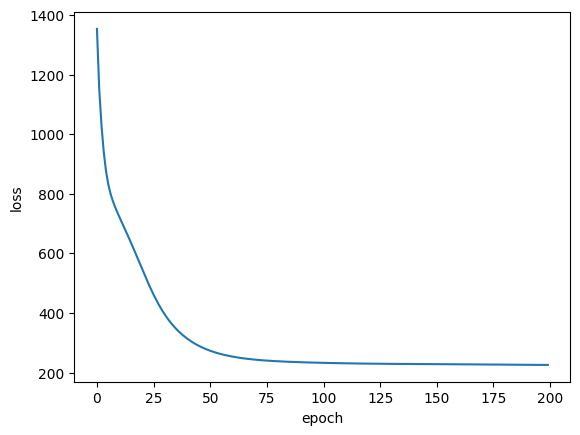

In [37]:
# plot the loss for evaluation
print("[INFO] Plotting loss...")
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")

In [38]:
# apply dimensional reductionality using tsne for the
# representation matrices
tsne_embed = (
	TSNE(n_components=2)
	.fit_transform(center_vector_matrix.numpy())
)
tsne_decode = (
	TSNE(n_components=2)
	.fit_transform(context_vector_matrix.numpy())
)

In [41]:
# build a dataset of tsne for plotly
skip_tsne_df = pd.DataFrame(
    {
        "x": tsne_embed[:100, 0],
        "y": tsne_embed[:100, 1],
        "word": index_to_vocab[list(range(100))]
    }
)

In [42]:
# plot tsne
px.scatter(data_frame=skip_tsne_df, x="x", y="y", hover_data="word")